# UFC Fight Duration Analysis

Authors: Titus Bridgwood, Ioana Preoteasa

In [40]:
import pandas as pd # The libraries we will be using for this notebook
import numpy as np
import statsmodels.stats as sms
import seaborn as sns
import matplotlib.pyplot as plt
import time
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import library as lib
import scipy.stats as stats
sns.set_style('darkgrid')
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction

This notebook is the technical document detailing our analysis of fight duration analysis. For our analysis we will be using some of the more advanced regression techniques and will hopefully demonstrate a replicable process for handling and analysing data.

We have used a dataset of historical data for the UFC from 1993 to 2019 (https://www.kaggle.com/rajeevw/ufcdata#raw_total_fight_data.csv), containing information for all individual UFC bouts during this time period. The data set ostensibly contains two useful targets: the winner of the fight, and the length of the fight. Although it would be nice to see whether variables contained within this dataset can consistently predict wins, as winning (or not) is a binary categorical taget, and as such would lend itself to classification. On the other hand we can take match times, convert them into seconds and see whether the many variables in this dataset are capable or making decent predictions or fight length.

While there are lots of lovely in-fight statistics such as significant strike rates, takedown percentages and much more, we will be mostly looking at prior information for these fights such as the heights and weights of the fighters, how many successive wins the fighters have had etc. This is because we want our model to have predictive capabilities for business use cases such as deciding betting odds, and aside from the ultimate winner, the next most common betting target is the length of the fight ('I want him to go down in the 4th!'). While we've got our models up and running we are going to try and see whether we can change our target variable to something more nuanced like predicting strike percentage. 

## Dataset & Data Cleaning

There was a decent amount of cleaning for us to do with this set. Many of the columns were encoded as `object` types, especially any columns containing percentages, so we were sure to turn them from percentages into 0 to 1 floats. 

With this historical data we have to account for the fact that the rules have changed progressively throughout the history of the UFC. Round lengths of five minutes were introduced in UFC 21, and we suspect this might have an effect on estimations of match length, we will be sure to run models both both with and without matches before UFC 21. 

In [41]:
# gather
time_df = pd.read_pickle('time_predictFINAL.pkl')
# clean
xtime_df = time_df[time_df.columns[11:39]]
ytime_df = time_df[time_df.columns[39]]
xtime_df.drop(columns=['fighter', 'total_rounds_fought', 'total_time_fought(seconds)', 'Stance'], inplace=True)

## Feature Selection and Regularization

Our features are for the most part pretty different and very difficult compare to one another. For this reason we've normalised them with `sklearn`'s `normalize`. 

As for feature selection, it seems intuitively as though there will be some colinearity that we may at some point have to account for. 

We will be using Lasso regression, a form of regression that weights coefficients of a model so that some coefficients aren't producing too much of an effect on the model. Lasso differs from Ridge regression in that it is bounded, meaning that if a feature's weight will be reduced to 0 if its weighting is reduced to a certain level. To a certain extent this is a hands off way of letting sklearn's optimization select features for us.

We will also using polynomial preprocessing which will create a feature matrix of all the possible polynomial combinations for features. This will produce more nuanced features for our model but also runs the risk of creating a model that is overfitted to our training data and is less capable of generalizing to new and unseen data. For this reason we will be trying a number of different options for our level of polynomial preprocessing and the alpha threshold we set for our Lasso model.

We will be creating a training and testing split in order to see whether our model is capable of generalising to new data rather than simply perfectly fitting the data we already have. 

In [42]:
# Creating a split between training and testing data(80% Train, 20% Test)
x_train, x_test, y_train, y_test = train_test_split(xtime_df, ytime_df, test_size=.2, random_state=42)

## Modelling 

We will initially be trying to obtain as simple a model as possible, in order to produce a baseline which we can work upon by introducing greater complexity to the model iteratively. We will be using all of the possible x variables to predict fight duration to begin with, and LASSO should then start to deweight those deemed unimportant. 

We have produced a library with code that should speed this process up and make results easier to interpret. The alpha in LASSO regression changes the extent to which features are deweighted, so if we set our initial alpha to 0 this essentially tells LASSO to perform an Ordinary Least Squares regression. With polynomial feature order set to 1 the model will also produce a straight line. 


In [43]:
time_baseline = lib.modeling(x_train, x_test, y_train, y_test, lasso_alpha=0, kfold=True, k_n_splits=5);

The R-2 for a model with with a Polynomial Order of 1 and a Lasso Alpha of 0 is 0.055.
  Function returns a tuple indexed as follows:  
  0 - Sklearn lasso-regression object  
  1 - training X data (np array) 
 2 - testing X data (np array) 
   3  -  Model results table (pandas DataFrame obj)  
  4  -  training Y data (np array)  
  5  -  testing Y data (np array) 


Great so now we have a baseline R-squared score (although perhaps not the strongest) of `0.055`. We can start to introduce some complexity into the model now to see if we can predict the fight duration any more convincingly. We'll start by adding second order polynomial features, which will produce pair wise interactions for all of the features in the dataset. 

In [44]:
time_poly2 = lib.modeling(x_train, x_test, y_train, y_test,
                          poly_order=2,
                          lasso_alpha=0,
                          kfold=True,
                          k_n_splits=5
                         );

The R-2 for a model with with a Polynomial Order of 2 and a Lasso Alpha of 0 is 0.0113.
  Function returns a tuple indexed as follows:  
  0 - Sklearn lasso-regression object  
  1 - training X data (np array) 
 2 - testing X data (np array) 
   3  -  Model results table (pandas DataFrame obj)  
  4  -  training Y data (np array)  
  5  -  testing Y data (np array) 


A non linear model actually performs worse than our baseline, and the number of features we are using probably means that the complexity necessary to fit our training data is not general enough to predict values in our test data. From here we can manually set the alpha value for our LASSO regression so that it will start to weight the coefficients. We have started with an alpha value of 0.001 as we found it to be quite effective in our initial tests. 

In [45]:
time_poly2_alpha = lib.modeling(x_train, x_test, y_train, y_test, 
                                poly_order=2, 
                                lasso_alpha=0.001,
                                kfold=True,
                                k_n_splits=5
                                );

The R-2 for a model with with a Polynomial Order of 2 and a Lasso Alpha of 0.001 is 0.0263.
  Function returns a tuple indexed as follows:  
  0 - Sklearn lasso-regression object  
  1 - training X data (np array) 
 2 - testing X data (np array) 
   3  -  Model results table (pandas DataFrame obj)  
  4  -  training Y data (np array)  
  5  -  testing Y data (np array) 


This model performs significanlty better than the unweighted polynomial regression. From here we could manually plug and chug a series of different alpha values, however SKLearn has a nifty built-in, `LassoLarsIC`, that optimizes both the weighting for the coefficients *and* the alpha by performing several iterations of the Lasso regression with different values for both. It optimises based on an information criterion that we choose.

We have chosen the Bayesian Information Criterion (BIC) as opposed to the Akaike Information Criterion (AIC) as the AIC reportedly prefers more complex but less true models over simpler truer models. The lower our BIC the better our model. 

By default we run 1000 iterations but later we will hone the estimate by trying many more iterations.

In [46]:
time_poly2_larsic = lib.modeling(x_train, x_test, y_train, y_test, 
                                 poly_order=2, 
                                 iterations=1000,
                                 criterion='bic',
                                 lars_ic=True,
                                 kfold=True,
                                 k_n_splits=5
                                );

The R-2 for a LASSO Least Angle Regression model with with a Polynomial Order of 2 is 0.05392706583609608.
 The model with the lowest bic of 8844.141470954952 has a LASSO alpha of 16.996732658311497 
 Function returns a tuple indexed as follows: 
 0 - Sklearn lasso-regression object  
  1 - training X data (np array) 
 2 - testing X data (np array)  
 3  -  Model results table (pandas DataFrame obj) 
  4  -  training Y data (np array)  
  5  -  testing Y data (np array)


Now lets try third order polynomial features:

In [47]:
time_poly3_larsic = lib.modeling(x_train, x_test, y_train, y_test, 
                                 poly_order=3, 
                                 iterations=1000,
                                 criterion='bic',
                                 lars_ic=True,
                                 kfold=True,
                                 k_n_splits=5
                                );

The R-2 for a LASSO Least Angle Regression model with with a Polynomial Order of 3 is 0.03501423551066252.
 The model with the lowest bic of 10106.22063313312 has a LASSO alpha of 50.85328572445491 
 Function returns a tuple indexed as follows: 
 0 - Sklearn lasso-regression object  
  1 - training X data (np array) 
 2 - testing X data (np array)  
 3  -  Model results table (pandas DataFrame obj) 
  4  -  training Y data (np array)  
  5  -  testing Y data (np array)


Now we will iterate the model with the best score a million times in order to make sure that we are really converging on the best possible alpha with the lowest possible BIC. We will also use a five fold cross validation to check the validity of this model. 

In [48]:
time_poly2_larsic_1m = lib.modeling(x_train, x_test, y_train, y_test, 
                                 poly_order=2, 
                                 iterations=1000000,
                                 criterion='bic',
                                 lars_ic=True,
                                 kfold=True,
                                 k_n_splits=5
                                );

The R-2 for a LASSO Least Angle Regression model with with a Polynomial Order of 2 is 0.05392706583609608.
 The model with the lowest bic of 8844.141470954952 has a LASSO alpha of 16.996732658311497 
 Function returns a tuple indexed as follows: 
 0 - Sklearn lasso-regression object  
  1 - training X data (np array) 
 2 - testing X data (np array)  
 3  -  Model results table (pandas DataFrame obj) 
  4  -  training Y data (np array)  
  5  -  testing Y data (np array)


We have a lot of information stored in our model variables so lets take a look at this information now in order to assess how our model has performed. 

In [49]:
list = [time_baseline[3], 
time_poly2[3], 
time_poly2_alpha[3], 
time_poly2_larsic[3], 
time_poly3_larsic[3], 
time_poly2_larsic_1m[3]]

for i, c in enumerate(list):
    print(i, type(c))

0 <class 'pandas.core.frame.DataFrame'>
1 <class 'pandas.core.frame.DataFrame'>
2 <class 'pandas.core.frame.DataFrame'>
3 <class 'pandas.core.frame.DataFrame'>
4 <class 'pandas.core.frame.DataFrame'>
5 <class 'pandas.core.frame.DataFrame'>


In [50]:
time_model_df = pd.concat([time_baseline[3], 
                           time_poly2[3], 
                           time_poly2_alpha[3], 
                           time_poly2_larsic[3], 
                           time_poly3_larsic[3], 
                           time_poly2_larsic_1m[3]],
                          axis=0)
time_model_df

,R2,bic,Optimal_alpha,Mean_cvs
TIME_polyO1_5ksplits,0.054977,NaN,NaN,0.067798
TIME_polyO2_5ksplits,0.011290,NaN,NaN,-0.451234
TIME_polyO2_5ksplits,0.026338,NaN,NaN,0.023284
TIME_polyO2_5ksplits,0.053927,8844.141471,16.996733,0.055992
TIME_polyO3_5ksplits,0.035014,10106.220633,50.853286,-0.112056
TIME_polyO2_5ksplits_iter1000000,0.053927,8844.141471,16.996733,0.055992


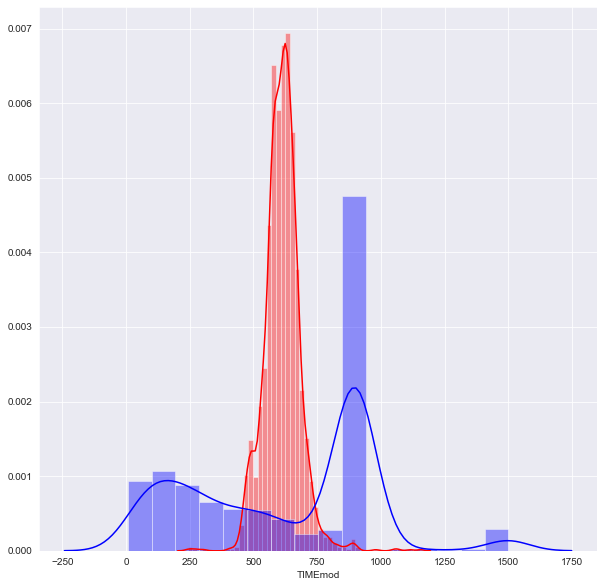

<Figure size 720x720 with 0 Axes>

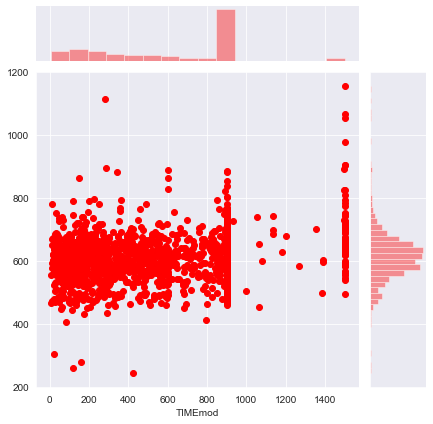

<Figure size 720x720 with 0 Axes>

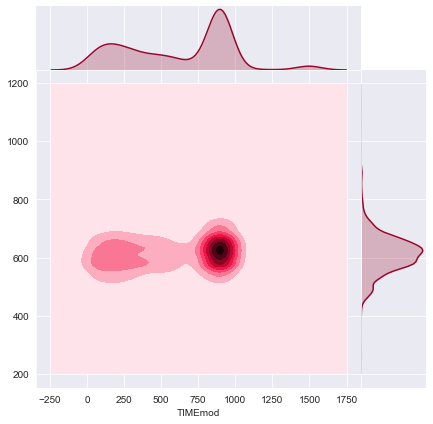

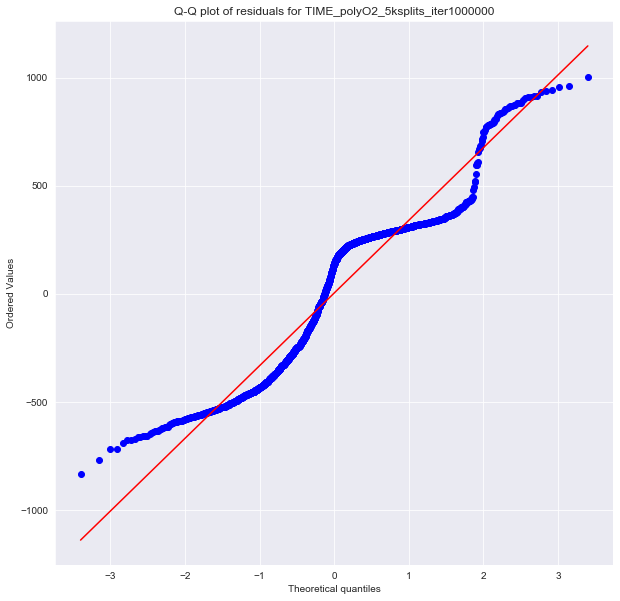

In [55]:
# visualizing the results:
final_models = [time_poly2_larsic_1m]

for model in final_models:
    plt.figure(figsize=(10,10))
    sns.distplot(model[0].predict(model[2]), color='r')
    sns.distplot(model[5], color='b')
    
    plt.figure(figsize=(10,10))
    sns.jointplot(x=model[5], y=model[0].predict(model[2]), color='r')
    
    plt.figure(figsize=(10,10))
    sns.jointplot(
    x = model[5],
    y = model[0].predict(model[2]),
    kind = 'kde',
    color = '#990628',
    space = 0)
#   plotting residuals
    resid = model[5] - model[0].predict(model[2])
    
    plt.show()
    
    plt.figure(figsize=(10,10))
    stats.probplot(resid, dist="norm", plot=plt)
    plt.title(f"Q-Q plot of residuals for {model[3].index[0]}")
    
    
    plt.show()



## Refinement

### Striking

So unfortunately it seems as though no matter how complex a model we produce, it is pretty difficult to predic the length of a fight based off prefight data. However there are other targets to which we could turn our attention, such as for example the percentage of significant strikes landed. So let's repeat the above process but this time taking significant strike percentage as our target variable. 

In [51]:
# Fight stat analysis now comes for the pct sig strikes landed

# gather
fstat_df = pd.read_pickle('post2001_norm_str_pct.pkl')

# clean
xstat_df = fstat_df[fstat_df.columns[2:26]]
ystat_df = fstat_df['avg_SIG_STR_pct']

# tt_split; 'ss' refers to 'significant strikes', because str would have been confusing
xss_train, xss_test, yss_train, yss_test = train_test_split(xstat_df, ystat_df, test_size=.2, random_state=42)

# modeling - OLS
sig_str_baseline = lib.modeling(xss_train, xss_test, yss_train, yss_test, lasso_alpha=0)

# polynomial models with Lasso
poly1_larsic_ss = lib.modeling(xss_train, xss_test, yss_train, yss_test, lars_ic=True, kfold=True, k_n_splits=5)
poly2_larsic_ss = lib.modeling(xss_train, xss_test, yss_train, yss_test, lars_ic=True, poly_order=2, kfold=True, k_n_splits=5)
poly3_larsic_ss = lib.modeling(xss_train, xss_test, yss_train, yss_test, lars_ic=True, poly_order=3, kfold=True, k_n_splits=5)
poly2_larsic_ss_1m = lib.modeling(xss_train, xss_test, yss_train, yss_test, lars_ic=True, poly_order=2, kfold=True, k_n_splits=5, iterations=1000000)

modeling_SS_df = pd.concat([sig_str_baseline[3], poly1_larsic_ss[3],poly2_larsic_ss[3],poly3_larsic_ss[3], poly2_larsic_ss_1m[3]], axis=0)
modeling_SS_df

The R-2 for a model with with a Polynomial Order of 1 and a Lasso Alpha of 0 is 0.1391.
  Function returns a tuple indexed as follows:  
  0 - Sklearn lasso-regression object  
  1 - training X data (np array) 
 2 - testing X data (np array) 
   3  -  Model results table (pandas DataFrame obj)  
  4  -  training Y data (np array)  
  5  -  testing Y data (np array) 
The R-2 for a LASSO Least Angle Regression model with with a Polynomial Order of 1 is 0.13752799525381731.
 The model with the lowest bic of 5760.263965708646 has a LASSO alpha of 0.00022327941226460863 
 Function returns a tuple indexed as follows: 
 0 - Sklearn lasso-regression object  
  1 - training X data (np array) 
 2 - testing X data (np array)  
 3  -  Model results table (pandas DataFrame obj) 
  4  -  training Y data (np array)  
  5  -  testing Y data (np array)
The R-2 for a LASSO Least Angle Regression model with with a Polynomial Order of 2 is 0.15822202234438698.
 The model with the lowest bic of 6336.460891

,R2,bic,Optimal_alpha,Mean_cvs
avg__polyO1_2ksplits,0.139112,NaN,NaN,0.109887
avg__polyO1_5ksplits,0.137528,5760.263966,0.000223,0.104738
avg__polyO2_5ksplits,0.158222,6336.460891,0.002696,0.113615
avg__polyO3_5ksplits,0.140723,6899.923302,0.006092,0.040550
avg__polyO2_5ksplits_iter1000000,0.158222,6336.460891,0.002696,0.113615


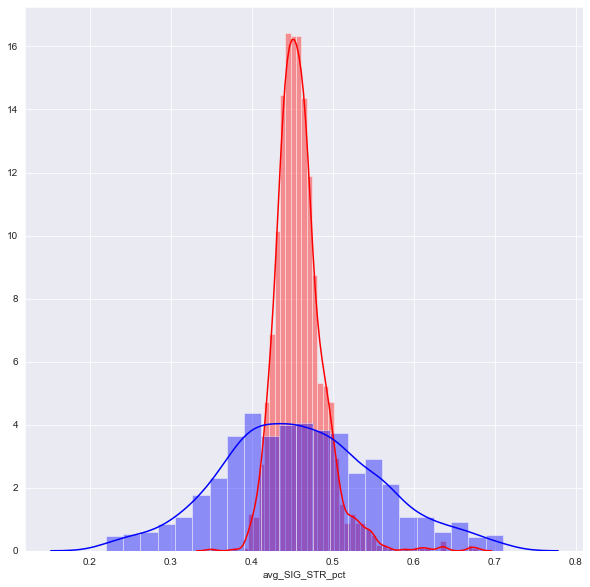

<Figure size 720x720 with 0 Axes>

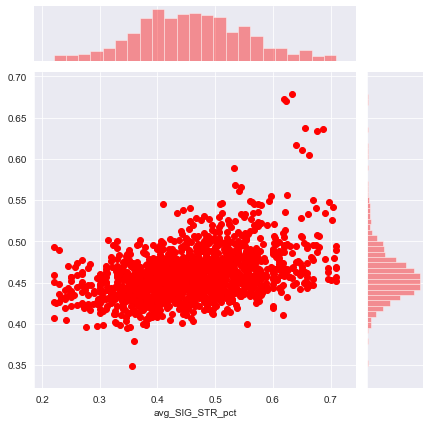

<Figure size 720x720 with 0 Axes>

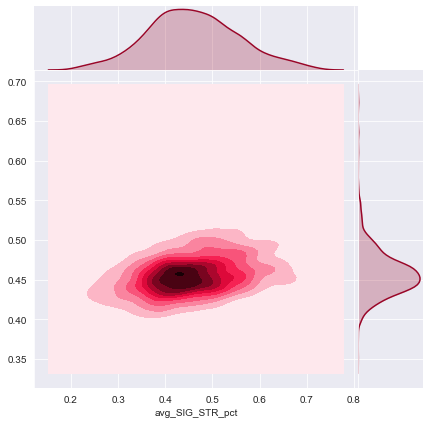

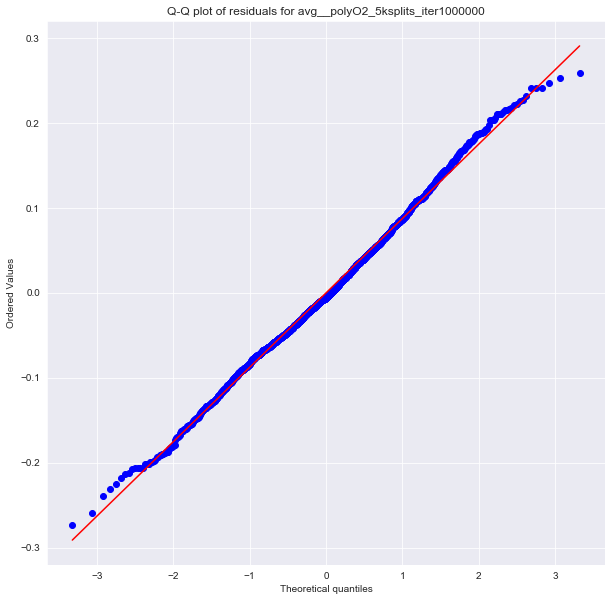

In [54]:
# visualizing the results:
final_models = [poly2_larsic_ss_1m]

for model in final_models:
    plt.figure(figsize=(10,10))
    sns.distplot(model[0].predict(model[2]), color='r')
    sns.distplot(model[5], color='b')
    
    plt.figure(figsize=(10,10))
    sns.jointplot(x=model[5], y=model[0].predict(model[2]), color='r')
    
    plt.figure(figsize=(10,10))
    sns.jointplot(
    x = model[5],
    y = model[0].predict(model[2]),
    kind = 'kde',
    color = '#990628',
    space = 0)
#   plotting residuals
    resid = model[5] - model[0].predict(model[2])
    
    plt.show()
    
    plt.figure(figsize=(10,10))
    stats.probplot(resid, dist="norm", plot=plt)
    plt.title(f"Q-Q plot of residuals for {model[3].index[0]}")
    
    
    plt.show()



Here we have much more promising results, our best model is much better at predicting significant strike percentage than our previous attempts at modelling. 

**However** The model with the highest R-squared is not the model with the lowest information criterion. So we should instead look to pick the most basic model possible. 

This is based off of BIC and we wanted to see whether AIC would be any more or less judicious.

In [52]:
# Trying AIC as the guiding criterion
poly2_larsic_ss_1m_aic = lib.modeling(xss_train, xss_test, yss_train, yss_test, 
                                  lars_ic=True, 
                                  poly_order=2, 
                                  kfold=True, 
                                  k_n_splits=5, 
                                  iterations=1000000,
                                  criterion='aic');


The R-2 for a LASSO Least Angle Regression model with with a Polynomial Order of 2 is 0.2063218855577036.
 The model with the lowest aic of 5242.019930480519 has a LASSO alpha of 0.00017961761388468484 
 Function returns a tuple indexed as follows: 
 0 - Sklearn lasso-regression object  
  1 - training X data (np array) 
 2 - testing X data (np array)  
 3  -  Model results table (pandas DataFrame obj) 
  4  -  training Y data (np array)  
  5  -  testing Y data (np array)


The AIC seems to be much less judicious, however this might be to the detriment of the predictive capability of our model.

### Takedowns

Now let's run our model for take downs to see how well it performs:

In [56]:
# now again we do the same, but for the pct of successful takedowns. We will have to cutout 
# the outliers from our data

# input df stays the same
ytd_df = fstat_df['avg_TD_pct']

# tt_split; 'td' - takedowns
xtd_train, xtd_test, ytd_train, ytd_test = train_test_split(xstat_df, ytd_df, test_size=.2, random_state=42)

# modeling - OLS
sig_td_baseline = lib.modeling(xtd_train, xtd_test, ytd_train, ytd_test, lasso_alpha=0)

# polynomial orders with Lasso
poly1_larsic_td = lib.modeling(xtd_train, xtd_test, ytd_train, ytd_test, lars_ic=True, kfold=True, k_n_splits=5)
poly2_larsic_td = lib.modeling(xtd_train, xtd_test, ytd_train, ytd_test, lars_ic=True, poly_order=2, kfold=True, k_n_splits=5)
poly3_larsic_td = lib.modeling(xtd_train, xtd_test, ytd_train, ytd_test, lars_ic=True, poly_order=3, kfold=True, k_n_splits=5)
poly2_larsic_td_1m = lib.modeling(xtd_train, xtd_test, ytd_train, ytd_test, lars_ic=True, poly_order=2, kfold=True, k_n_splits=5, iterations=1000000)

modelling_TD_df = pd.concat([sig_td_baseline[3], poly1_larsic_td[3],poly2_larsic_td[3],poly3_larsic_td[3], poly2_larsic_td_1m[3]], axis=0)
modelling_TD_df

The R-2 for a model with with a Polynomial Order of 1 and a Lasso Alpha of 0 is 0.0808.
  Function returns a tuple indexed as follows:  
  0 - Sklearn lasso-regression object  
  1 - training X data (np array) 
 2 - testing X data (np array) 
   3  -  Model results table (pandas DataFrame obj)  
  4  -  training Y data (np array)  
  5  -  testing Y data (np array) 
The R-2 for a LASSO Least Angle Regression model with with a Polynomial Order of 1 is 0.08110874369134558.
 The model with the lowest bic of 5887.302641809418 has a LASSO alpha of 0.00013825188834428319 
 Function returns a tuple indexed as follows: 
 0 - Sklearn lasso-regression object  
  1 - training X data (np array) 
 2 - testing X data (np array)  
 3  -  Model results table (pandas DataFrame obj) 
  4  -  training Y data (np array)  
  5  -  testing Y data (np array)
The R-2 for a LASSO Least Angle Regression model with with a Polynomial Order of 2 is 0.08883771315962652.
 The model with the lowest bic of 6539.150055

,R2,bic,Optimal_alpha,Mean_cvs
avg__polyO1_2ksplits,0.080793,NaN,NaN,0.083822
avg__polyO1_5ksplits,0.081109,5887.302642,0.000138,0.078200
avg__polyO2_5ksplits,0.088838,6539.150056,0.007406,0.095000
avg__polyO3_5ksplits,0.020973,7522.576689,0.049496,0.022712
avg__polyO2_5ksplits_iter1000000,0.088838,6539.150056,0.007406,0.095000


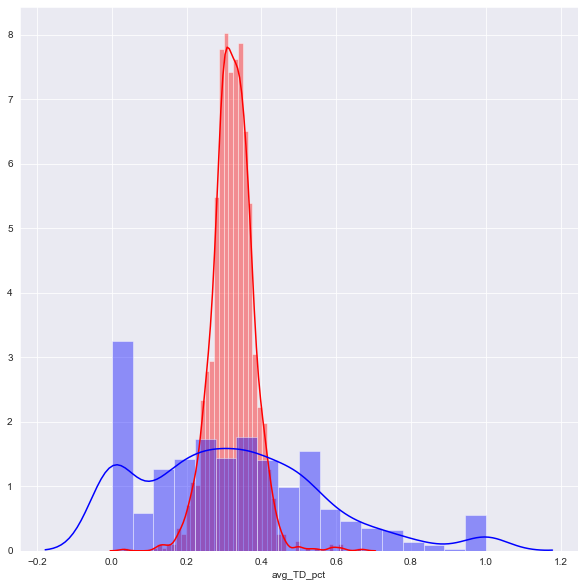

<Figure size 720x720 with 0 Axes>

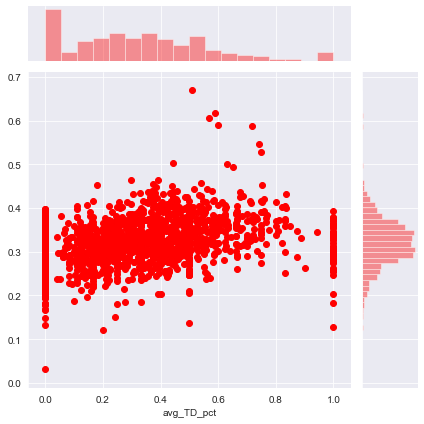

<Figure size 720x720 with 0 Axes>

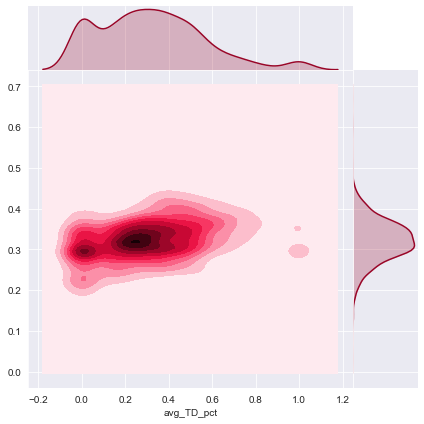

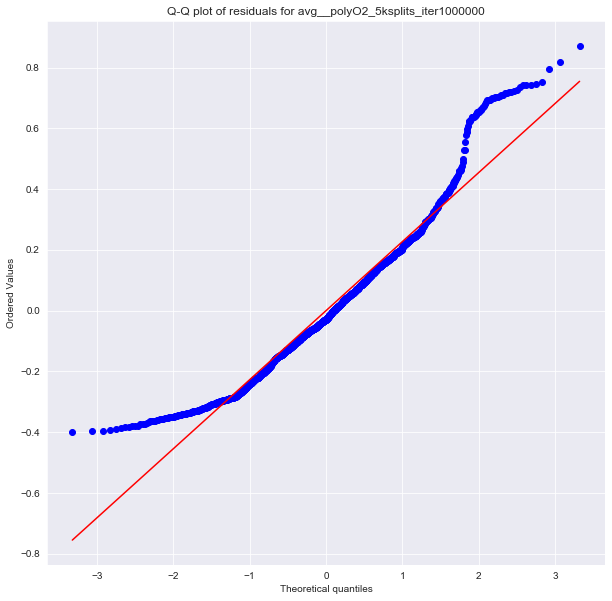

In [57]:
# visualizing the results:
final_models = [poly2_larsic_td_1m]

for model in final_models:
    plt.figure(figsize=(10,10))
    sns.distplot(model[0].predict(model[2]), color='r')
    sns.distplot(model[5], color='b')
    
    plt.figure(figsize=(10,10))
    sns.jointplot(x=model[5], y=model[0].predict(model[2]), color='r')
    
    plt.figure(figsize=(10,10))
    sns.jointplot(
    x = model[5],
    y = model[0].predict(model[2]),
    kind = 'kde',
    color = '#990628',
    space = 0)
#   plotting residuals
    resid = model[5] - model[0].predict(model[2])
    
    plt.show()
    
    plt.figure(figsize=(10,10))
    stats.probplot(resid, dist="norm", plot=plt)
    plt.title(f"Q-Q plot of residuals for {model[3].index[0]}")
    
    
    plt.show()

## Conclusions

The data available to us was provided somewhat useful predictions of the fight outcome variables we chose, with the most notable predictions being for the percentage of successful strikes. We do believe that if we added further exogenous variables about fighters (e.g. which gym they train in, what their martial arts background is) we would be able to produce better results. 